In [195]:
# ============================================================
# Olist E-commerce EDA (Colab-ready)
# - Load Olist datasets
# - Basic cleaning / validation
# - Bundle cleaned tables into `clean` dict
# ============================================================

# 1) Setup and imports
import os
import pandas as pd
import numpy as np
import seaborn as sns

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)

# 2) Load data (simple and explicit)
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/Olist_데이터분석팀프로젝트"  # <- change if your files are elsewhere

def load_csv(filename: str) -> pd.DataFrame:
    path = os.path.join(DATA_DIR, filename)
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"Cannot find {filename} at {path}. "
            f"Upload CSVs to {DATA_DIR} or update DATA_DIR."
        )
    return pd.read_csv(path)

orders = load_csv("olist_orders_dataset.csv")
customers = load_csv("olist_customers_dataset.csv")
order_items = load_csv("olist_order_items_dataset.csv")
payments = load_csv("olist_order_payments_dataset.csv")
reviews = load_csv("olist_order_reviews_dataset.csv")
products = load_csv("olist_products_dataset.csv")
sellers = load_csv("olist_sellers_dataset.csv")
geolocation = load_csv("olist_geolocation_dataset.csv")

print("orders", orders.shape)
print("customers", customers.shape)
print("order_items", order_items.shape)
print("payments", payments.shape)
print("reviews", reviews.shape)
print("products", products.shape)
print("sellers", sellers.shape)
print("geolocation", geolocation.shape)

# 3) Review cleanup (simple version)
# If the same order has identical score/text, keep only one record.
reviews_dedup = reviews.copy()

# Make sure timestamps are proper datetime
reviews_dedup["review_answer_timestamp"] = pd.to_datetime(
    reviews_dedup["review_answer_timestamp"], errors="coerce"
)

# Sort so the latest review stays when duplicates exist
reviews_dedup = reviews_dedup.sort_values("review_answer_timestamp")

# Remove exact duplicates by order + content + score
reviews_dedup = reviews_dedup.drop_duplicates(
    subset=["order_id", "review_score", "review_comment_title", "review_comment_message"],
    keep="last",
)

print("reviews before:", len(reviews))
print("reviews after dedup:", len(reviews_dedup))

# 4) Order date cleanup (simple version)
# If a later date happens before an earlier date, set the later one to NaT.
orders_fix = orders.copy()

# Parse dates
orders_fix["order_purchase_timestamp"] = pd.to_datetime(
    orders_fix["order_purchase_timestamp"], errors="coerce"
)
orders_fix["order_approved_at"] = pd.to_datetime(orders_fix["order_approved_at"], errors="coerce")
orders_fix["order_delivered_carrier_date"] = pd.to_datetime(
    orders_fix["order_delivered_carrier_date"], errors="coerce"
)
orders_fix["order_delivered_customer_date"] = pd.to_datetime(
    orders_fix["order_delivered_customer_date"], errors="coerce"
)
orders_fix["order_estimated_delivery_date"] = pd.to_datetime(
    orders_fix["order_estimated_delivery_date"], errors="coerce"
)

# Flags
orders_fix["flag_approved_gt_carrier"] = (
    orders_fix["order_approved_at"] > orders_fix["order_delivered_carrier_date"]
)
orders_fix["flag_carrier_gt_delivered"] = (
    orders_fix["order_delivered_carrier_date"] > orders_fix["order_delivered_customer_date"]
)

# Fix impossible sequences
orders_fix.loc[orders_fix["flag_approved_gt_carrier"], "order_delivered_carrier_date"] = pd.NaT
orders_fix.loc[orders_fix["flag_carrier_gt_delivered"], "order_delivered_customer_date"] = pd.NaT

# Lead times (hours)
orders_fix["lead_purchase_to_approved_hr"] = (
    (orders_fix["order_approved_at"] - orders_fix["order_purchase_timestamp"])
    .dt.total_seconds()
    / 3600
)

orders_fix["lead_approved_to_carrier_hr"] = (
    (orders_fix["order_delivered_carrier_date"] - orders_fix["order_approved_at"])
    .dt.total_seconds()
    / 3600
)

orders_fix["lead_carrier_to_delivered_hr"] = (
    (orders_fix["order_delivered_customer_date"] - orders_fix["order_delivered_carrier_date"])
    .dt.total_seconds()
    / 3600
)

orders_fix["lead_purchase_to_delivered_hr"] = (
    (orders_fix["order_delivered_customer_date"] - orders_fix["order_purchase_timestamp"])
    .dt.total_seconds()
    / 3600
)

orders_fix["delay_days"] = (
    orders_fix["order_delivered_customer_date"] - orders_fix["order_estimated_delivery_date"]
).dt.days

print("approved>carrier flagged:", int(orders_fix["flag_approved_gt_carrier"].sum()))
print("carrier>delivered flagged:", int(orders_fix["flag_carrier_gt_delivered"].sum()))

# 5) Product cleanup (simple version)
# Fill missing categories and set invalid weights to NaN.
products_fix = products.copy()

products_fix["product_category_name"] = products_fix["product_category_name"].fillna("Unknown")
products_fix["product_category_name"] = products_fix["product_category_name"].astype(str).str.strip()
products_fix.loc[products_fix["product_category_name"] == "", "product_category_name"] = "Unknown"

products_fix.loc[products_fix["product_weight_g"] <= 0, "product_weight_g"] = pd.NA

print("Unknown category:", int((products_fix["product_category_name"] == "Unknown").sum()))
print("weight NaN:", int(products_fix["product_weight_g"].isna().sum()))

# 6) Payment cleanup (simple version)
# Flag non-positive payment values and keep a positive-only view.
payments_fix = payments.copy()
payments_fix["flag_payment_le_0"] = payments_fix["payment_value"] <= 0

payments_pos = payments_fix[payments_fix["payment_value"] > 0].copy()

print("payments total:", len(payments_fix))
print("payments <= 0:", int(payments_fix["flag_payment_le_0"].sum()))
print("payments_pos:", len(payments_pos))

# 7) Geolocation cleanup (simple version)
# Aggregate by zip prefix and keep representative city/state.
geo = geolocation.copy()

geolocation_fix = geo.groupby("geolocation_zip_code_prefix").agg(
    geolocation_lat=("geolocation_lat", "mean"),
    geolocation_lng=("geolocation_lng", "mean"),
    geolocation_city=("geolocation_city", lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0]),
    geolocation_state=("geolocation_state", lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0]),
    count=("geolocation_city", "size"),
).reset_index()

print("geolocation_fix:", geolocation_fix.shape)

# 8) Payment vs item totals check (simple version)
# Count orders with large discrepancies (abs delta > 100).
items_tot = order_items.groupby("order_id").agg(
    items_total=("price", "sum"),
    freight_total=("freight_value", "sum"),
)
items_tot["items_plus_freight"] = items_tot["items_total"] + items_tot["freight_total"]

pay_tot = payments.groupby("order_id").agg(payment_total=("payment_value", "sum"))

compare = items_tot.join(pay_tot, how="inner")
compare["delta"] = compare["payment_total"] - compare["items_plus_freight"]

large_delta = compare[compare["delta"].abs() > 100]
print("large deltas (abs>100):", len(large_delta))

# 9) Final cleaned dataset bundle
clean = {
    "orders": orders_fix,
    "customers": customers,
    "order_items": order_items,
    "payments": payments_fix,
    "payments_pos": payments_pos,
    "reviews": reviews_dedup,
    "products": products_fix,
    "sellers": sellers,
    "geolocation": geolocation_fix,
}

for k, v in clean.items():
    print(k, v.shape)


orders (99441, 8)
customers (99441, 5)
order_items (112650, 7)
payments (103886, 5)
reviews (99224, 7)
products (32951, 9)
sellers (3095, 4)
geolocation (1000163, 5)
reviews before: 99224
reviews after dedup: 98997
approved>carrier flagged: 1359
carrier>delivered flagged: 23
Unknown category: 610
weight NaN: 6
payments total: 103886
payments <= 0: 9
payments_pos: 103877
geolocation_fix: (19015, 6)
large deltas (abs>100): 3
orders (99441, 15)
customers (99441, 5)
order_items (112650, 7)
payments (103886, 6)
payments_pos (103877, 6)
reviews (98997, 7)
products (32951, 9)
sellers (3095, 4)
geolocation (19015, 6)


In [196]:
# 1) 파일 불러오기
products = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Olist_데이터분석팀프로젝트/olist_products_dataset.csv")
cat_trans = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Olist_데이터분석팀프로젝트/product_category_name_translation.csv")

# 2) 열 이름 확인 (혹시 encoding 이슈 있으면)
print(cat_trans.columns)

# 3) 병합 (merge)
products = products.merge(
    cat_trans,
    how="left",
    on="product_category_name"
)

# 4) 영어 이름으로 컬럼 정리
products["product_category_name_english"] = (
    products["product_category_name_english"]
    .fillna("unknown")
)

# (선택) 기존 포르투갈어 컬럼을 지우고 영어만 사용
# products = products.drop(columns=["product_category_name"])


Index(['product_category_name', 'product_category_name_english'], dtype='object')


In [197]:
for name, df in clean.items():
    print(f"\n===== {name.upper()} =====")
    display(df.head())


===== ORDERS =====


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,flag_approved_gt_carrier,flag_carrier_gt_delivered,lead_purchase_to_approved_hr,lead_approved_to_carrier_hr,lead_carrier_to_delivered_hr,lead_purchase_to_delivered_hr,delay_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,False,False,0.178333,56.795833,145.503611,202.477778,-8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,False,False,30.713889,11.109167,288.945833,330.768889,-6.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,False,False,0.276111,4.910278,220.274722,225.461111,-18.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,False,False,0.298056,89.900000,226.811944,317.010000,-13.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,False,False,1.030556,21.434722,46.507778,68.973056,-10.0



===== CUSTOMERS =====


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP



===== ORDER_ITEMS =====


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14



===== PAYMENTS =====


,order_id,payment_sequential,payment_type,payment_installments,payment_value,flag_payment_le_0
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,False
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,False
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,False
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,False
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,False



===== PAYMENTS_POS =====


,order_id,payment_sequential,payment_type,payment_installments,payment_value,flag_payment_le_0
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,False
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,False
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,False
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,False
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,False



===== REVIEWS =====


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
37547,6916ca4502d6d3bfd39818759d55d536,bfbd0f9bdef84302105ad712db648a6c,1,NaN,nao recebi o produto e nem resposta da empresa,2016-10-06 00:00:00,2016-10-07 18:32:28
5503,49f695dffa457eaba90d388a5c37e942,e5215415bb6f76fe3b7cb68103a0d1c0,1,NaN,"PRODUTO NÃO CHEGOU,E JÁ PASSOU O PRAZO DE ENTREGA",2016-10-09 00:00:00,2016-10-11 14:31:29
60439,743d98b1a4782f0646898fc915ef002a,e2144124f98f3bf46939bc5183104041,4,NaN,NaN,2016-10-15 00:00:00,2016-10-16 03:20:17
28075,53752edb26544dd41c1209f582c9c589,b8b9d7046c083150cb5360b83a8ebb51,5,NaN,O pedido foi entregue antes do prazo pr0metido,2016-10-16 01:00:00,2016-10-16 15:45:11
41042,b2d5d8db2a841d27a72e4c06c6212368,9aa3197e4887919fde0307fc23601d7a,4,NaN,Só chegou uma parte do pedido ate agora..,2016-10-15 00:00:00,2016-10-17 21:02:49



===== PRODUCTS =====


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0



===== SELLERS =====


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP



===== GEOLOCATION =====


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,count
0,1001,-23.550190,-46.634024,sao paulo,SP,26
1,1002,-23.548146,-46.634979,sao paulo,SP,13
2,1003,-23.548994,-46.635731,sao paulo,SP,17
3,1004,-23.549799,-46.634757,sao paulo,SP,22
4,1005,-23.549456,-46.636733,sao paulo,SP,25


In [198]:
industry_map = {
     # Home & Living
    "bed_bath_table": "Home & Living",
    "furniture_decor": "Home & Living",
    "office_furniture": "Home & Living",
    "furniture_living_room": "Home & Living",
    "housewares": "Home & Living",
    "home_construction": "Home & Living",
    "garden_tools": "Home & Living",

    # Tech & Electronics
    "computers_accessories": "Tech & Electronics",
    "pcs": "Tech & Electronics",
    "telephony": "Tech & Electronics",
    "home_appliances": "Tech & Electronics",
    "small_appliances": "Tech & Electronics",
    "air_conditioning": "Tech & Electronics",
    "electronics": "Tech & Electronics",
    "consoles_games": "Tech & Electronics",

    # Health & Beauty
    "perfumery": "Health & Beauty",
    "health_beauty": "Health & Beauty",

    # Sports & Leisure
    "sports_leisure": "Sports & Leisure",
    "musical_instruments": "Sports & Leisure",
    "art": "Sports & Leisure",

    # Fashion & Accessories
    "watches_gifts": "Fashion & Accessories",
    "luggage_accessories": "Fashion & Accessories",
    "fashion_bags_accessories": "Fashion & Accessories",
    "fashion_shoes": "Fashion & Accessories",

    # Kids & Toys
    "baby": "Kids & Toys",
    "toys": "Kids & Toys",

    # Automotive
    "auto": "Automotive",

    # 🔥 새로 분리
    "stationery": "Life Goods",
    "books_general_interest": "Life Goods",
    "cool_stuff": "Life Goods",

    "pet_shop": "Pet & Agro",
    "agro_industry_and_commerce": "Pet & Agro",

    "construction_tools_safety": "Construction & Safety",
    "signaling_and_security": "Construction & Safety",
}

products_fix=products
products_fix["industry"] = (
    products_fix["product_category_name_english"]
    .map(industry_map)
    .fillna("Others")
)

products.value_counts("industry")

,count
industry,
Home & Living,9464
Tech & Electronics,4332
Health & Beauty,3312
Sports & Leisure,3211
Others,2871
Fashion & Accessories,2700
Kids & Toys,2330
Automotive,1900
Life Goods,1854


In [199]:
items = order_items.merge(
    products_fix[["product_id", "industry"]],
    on="product_id",
    how="left"
)


In [200]:
order_industry_list = (
    items.groupby("order_id")["industry"]
         .unique()
         .reset_index(name="industry_list")
)


In [201]:
orders_base = (
    orders[["order_id", "customer_id", "order_purchase_timestamp"]]
    .merge(customers[["customer_id", "customer_unique_id"]], on="customer_id", how="left")
    .merge(order_industry_list, on="order_id", how="left")
)

orders_base["order_purchase_timestamp"] = pd.to_datetime(orders_base["order_purchase_timestamp"])
orders_base = orders_base.sort_values(["customer_unique_id", "order_purchase_timestamp"])


In [202]:
first_orders = (
    orders_base.groupby("customer_unique_id")
               .first()
               .reset_index()
)


In [203]:
first_orders = first_orders[
    first_orders["industry_list"].notna()
]


In [204]:
from itertools import permutations

pairs = []

for _, row in first_orders.iterrows():
    inds = list(set(row["industry_list"]))
    if len(inds) >= 2:
        for a, b in permutations(inds, 2):
            pairs.append((a, b))


In [205]:
import pandas as pd

pair_df = pd.DataFrame(pairs, columns=["first_industry", "included_industry"])

result = (
    pair_df.value_counts()
           .reset_index(name="count")
           .sort_values("count", ascending=False)
)

result.head(20)

,first_industry,included_industry,count
0,Others,Home & Living,124
1,Home & Living,Others,124
2,Home & Living,Kids & Toys,36
3,Kids & Toys,Home & Living,36
4,Kids & Toys,Life Goods,32
5,Life Goods,Kids & Toys,32
6,Home & Living,Tech & Electronics,27
7,Tech & Electronics,Home & Living,27
8,Home & Living,Life Goods,25
9,Life Goods,Home & Living,25


In [206]:
# order_items + product_fix
items = order_items.merge(
    products_fix[["product_id", "industry"]],
    on="product_id",
    how="left"
)

# 주문별 산업군 리스트
order_industry = (
    items.groupby("order_id")["industry"]
         .unique()
         .reset_index(name="industry_list")
)

# 고객 + 주문 시계열
base = (
    orders[["order_id", "customer_id", "order_purchase_timestamp"]]
    .merge(customers[["customer_id", "customer_unique_id"]], on="customer_id", how="left")
    .merge(order_industry, on="order_id", how="left")
)

base["order_purchase_timestamp"] = pd.to_datetime(base["order_purchase_timestamp"])
base = base.sort_values(["customer_unique_id", "order_purchase_timestamp"])

# 주문 순서
base["order_rank"] = base.groupby("customer_unique_id").cumcount() + 1


In [207]:
first_purchase = base[base["order_rank"] == 1][
    ["customer_unique_id", "industry_list"]
]


In [208]:
repeat_purchase = base[base["order_rank"] >= 2][
    ["customer_unique_id", "industry_list"]
]


In [209]:
import pandas as pd
import numpy as np
from itertools import product
from collections.abc import Iterable

def to_set(x):
    """industry_list를 안전하게 set으로 변환 (list/array/set/tuple/Series 대응)"""
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return set()
    # 문자열은 iterable이라도 리스트로 취급하면 안 됨
    if isinstance(x, str):
        return set([x])
    if isinstance(x, Iterable):
        return set(list(x))
    return set()

rows = []

# 고객별로 첫구매/재구매를 매칭 (빠르고 안전하게 dict로)
first_map = (
    first_purchase.drop_duplicates("customer_unique_id")
    .set_index("customer_unique_id")["industry_list"]
    .to_dict()
)

repeat_map = (
    repeat_purchase.groupby("customer_unique_id")["industry_list"]
    .apply(list)   # 고객별로 industry_list 묶음
    .to_dict()
)

for cid, first_raw in first_map.items():
    first_inds = to_set(first_raw)
    if not first_inds:
        continue

    repeat_raw_list = repeat_map.get(cid, [])
    if not repeat_raw_list:
        continue

    repeat_flat = set()
    for rr in repeat_raw_list:
        repeat_flat |= to_set(rr)

    if not repeat_flat:
        continue

    for f, r in product(first_inds, repeat_flat):
        rows.append((f, r))

transition_df = (
    pd.DataFrame(rows, columns=["first_industry", "repeat_industry"])
      .groupby(["first_industry", "repeat_industry"])
      .size()
      .reset_index(name="count")
      .sort_values("count", ascending=False)
)

transition_df.head(30)


,first_industry,repeat_industry,count
43,Home & Living,Home & Living,687
108,Tech & Electronics,Tech & Electronics,266
31,Health & Beauty,Health & Beauty,196
96,Sports & Leisure,Sports & Leisure,185
19,Fashion & Accessories,Fashion & Accessories,136
46,Home & Living,Others,64
49,Home & Living,Tech & Electronics,63
72,Others,Home & Living,63
102,Tech & Electronics,Home & Living,62
54,Kids & Toys,Kids & Toys,62


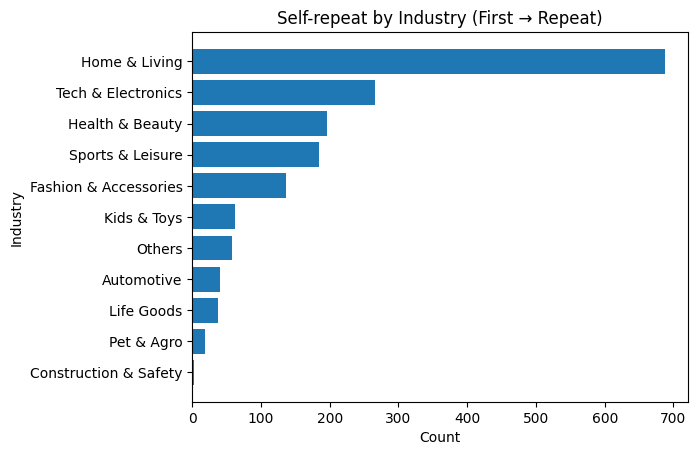

In [210]:
import matplotlib.pyplot as plt

self_loop = transition_df[
    transition_df["first_industry"] == transition_df["repeat_industry"]
].sort_values("count", ascending=False)

plt.figure()
plt.barh(self_loop["first_industry"], self_loop["count"])
plt.xlabel("Count")
plt.ylabel("Industry")
plt.title("Self-repeat by Industry (First → Repeat)")
plt.gca().invert_yaxis()
plt.show()


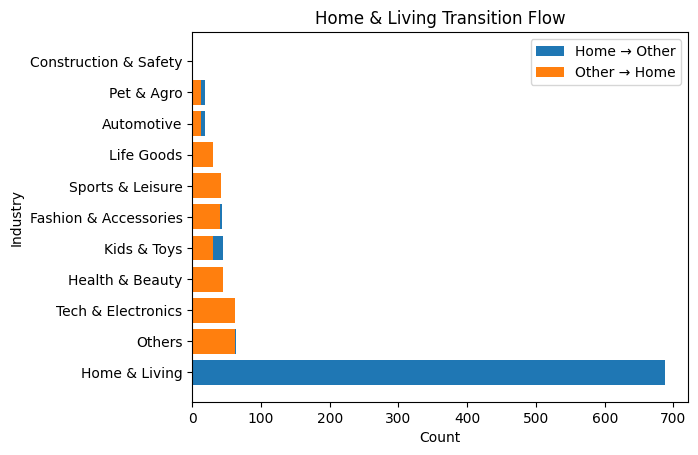

In [211]:
hl_flow = transition_df[
    (transition_df["first_industry"] == "Home & Living") |
    (transition_df["repeat_industry"] == "Home & Living")
].copy()

hl_flow["direction"] = hl_flow.apply(
    lambda x: "Home → Other" if x["first_industry"] == "Home & Living" else "Other → Home",
    axis=1
)

plt.figure()
for d in hl_flow["direction"].unique():
    sub = hl_flow[hl_flow["direction"] == d]
    plt.barh(
        sub["repeat_industry"] if d == "Home → Other" else sub["first_industry"],
        sub["count"],
        label=d
    )

plt.xlabel("Count")
plt.ylabel("Industry")
plt.title("Home & Living Transition Flow")
plt.legend()
plt.show()



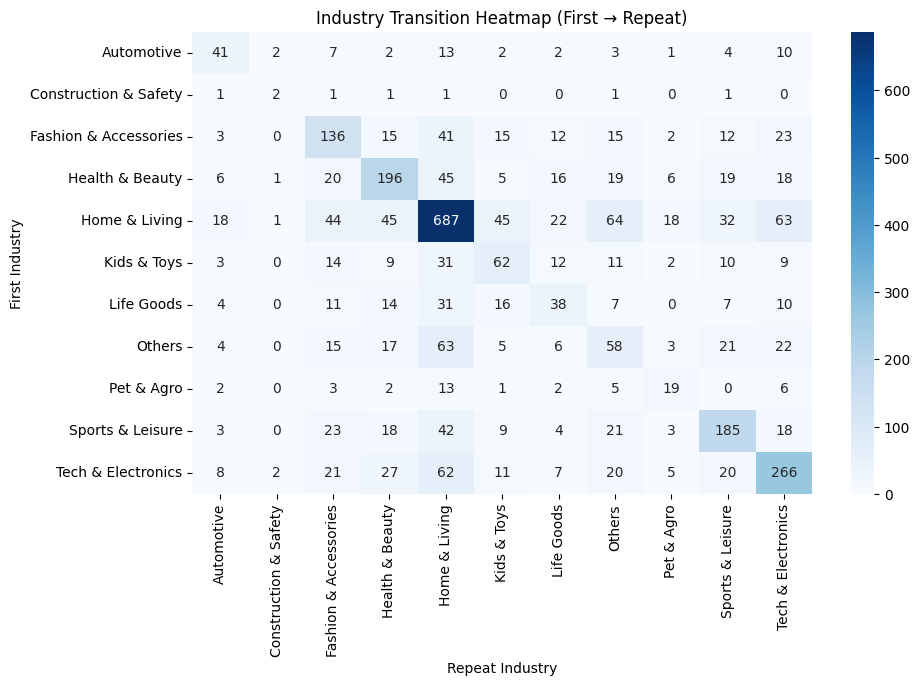

In [212]:
import seaborn as sns
import pandas as pd

pivot = transition_df.pivot(
    index="first_industry",
    columns="repeat_industry",
    values="count"
).fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="Blues")
plt.title("Industry Transition Heatmap (First → Repeat)")
plt.xlabel("Repeat Industry")
plt.ylabel("First Industry")
plt.show()


In [213]:
import pandas as pd

# 1. 판매 데이터 + 산업군
sales = (
    order_items
    .merge(products_fix[["product_id", "industry"]], on="product_id", how="left")
    .merge(orders[["order_id", "order_purchase_timestamp", "order_delivered_customer_date"]],
           on="order_id", how="left")
    .merge(sellers[["seller_id", "seller_state"]], on="seller_id", how="left")
)

# 매출 컬럼
sales["sales_amount"] = sales["price"] + sales["freight_value"]

# 배송기간 (일)
sales["delivery_days"] = (
    pd.to_datetime(sales["order_delivered_customer_date"]) -
    pd.to_datetime(sales["order_purchase_timestamp"])
).dt.days


In [214]:
seller_sales = (
    sales.groupby(["industry", "seller_id"])["sales_amount"]
         .sum()
         .reset_index()
)

seller_sales["rank"] = (
    seller_sales.groupby("industry")["sales_amount"]
                .rank(method="first", ascending=False)
)

top_sellers = seller_sales[seller_sales["rank"] <= 5]


In [215]:
review_agg = (
    reviews.groupby("order_id")["review_score"]
           .agg(["mean", "count"])
           .reset_index()
           .rename(columns={"mean": "avg_review_score", "count": "review_cnt"})
)

sales = sales.merge(review_agg, on="order_id", how="left")
sales

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,industry,order_purchase_timestamp,order_delivered_customer_date,seller_state,sales_amount,delivery_days,avg_review_score,review_cnt
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,Life Goods,2017-09-13 08:59:02,2017-09-20 23:43:48,SP,72.19,7.0,5.0,1.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,Pet & Agro,2017-04-26 10:53:06,2017-05-12 16:04:24,SP,259.83,16.0,4.0,1.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,Home & Living,2018-01-14 14:33:31,2018-01-22 13:19:16,MG,216.87,7.0,5.0,1.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,Health & Beauty,2018-08-08 10:00:35,2018-08-14 13:32:39,SP,25.78,6.0,4.0,1.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,Home & Living,2017-02-04 13:57:51,2017-03-01 16:42:31,PR,218.04,25.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,Home & Living,2018-04-23 13:57:06,2018-05-10 22:56:40,SC,343.40,17.0,5.0,1.0
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,Tech & Electronics,2018-07-14 10:26:46,2018-07-23 20:31:55,SP,386.53,9.0,5.0,1.0
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,Sports & Leisure,2017-10-23 17:07:56,2017-10-28 12:22:22,PR,116.85,4.0,5.0,1.0
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,Tech & Electronics,2017-08-14 23:02:59,2017-08-16 21:59:40,SP,64.71,1.0,5.0,1.0


In [216]:
seller_metrics = (
    sales.merge(top_sellers[["industry", "seller_id"]], on=["industry", "seller_id"])
    .groupby(["industry", "seller_id"])
    .agg(
        total_sales=("sales_amount", "sum"),
        product_cnt=("product_id", "nunique"),
        avg_review_score=("avg_review_score", "mean"),
        review_cnt=("review_cnt", "sum"),
        avg_delivery_days=("delivery_days", "mean"),
        seller_state=("seller_state", "first")
    )
    .reset_index()
)

seller_total_metrics = (
    sales
    .groupby(["industry", "seller_id"])
    .agg(
        total_sales=("sales_amount", "sum"),
        product_cnt=("product_id", "nunique"),
        avg_review_score=("avg_review_score", "mean"),
        review_cnt=("review_cnt", "sum"),
        avg_delivery_days=("delivery_days", "mean"),
        seller_state=("seller_state", "first"),
    )
    .reset_index()
)



In [217]:
# 셀러 × 상품 매출
product_sales = (
    sales.merge(top_sellers[["industry", "seller_id"]], on=["industry", "seller_id"])
    .groupby(["industry", "seller_id", "product_id"])["sales_amount"]
    .sum()
    .reset_index()
)

# 셀러별 최대 매출 상품
top_product = (
    product_sales.sort_values("sales_amount", ascending=False)
    .groupby(["industry", "seller_id"])
    .first()
    .reset_index()
    .rename(columns={
        "product_id": "top_product_id",
        "sales_amount": "top_product_sales"
    })
)

# 비중 계산
seller_metrics = seller_metrics.merge(top_product, on=["industry", "seller_id"])

seller_metrics["top_product_ratio"] = (
    seller_metrics["top_product_sales"] / seller_metrics["total_sales"]
)


In [218]:
seller_metrics.sort_values(["industry", "total_sales"], ascending=[True, False])


,industry,seller_id,total_sales,product_cnt,avg_review_score,review_cnt,avg_delivery_days,seller_state,top_product_id,top_product_sales,top_product_ratio
3,Automotive,8581055ce74af1daba164fdbd55a40de,74584.30,32,4.225806,442.0,12.340376,SP,f4f67ccaece962d013a4e1d7dc3a61f7,14747.13,0.197724
1,Automotive,712e6ed8aa4aa1fa65dab41fed5737e4,46704.13,24,3.453488,87.0,23.388235,SC,1dec4c88c685d5a07bf01dcb0f8bf9f8,22228.51,0.475943
2,Automotive,7142540dd4c91e2237acb7e911c4eba2,33175.38,187,4.010917,230.0,13.096916,SP,577c6116dcce6a33261911b5225ac475,1874.57,0.056505
4,Automotive,b1b3948701c5c72445495bd161b83a4c,25185.49,4,1.722222,18.0,22.928571,SP,fd0065af7f09af4b82a0ca8f3eed1852,22367.88,0.888126
0,Automotive,40db9e9aa57f7bb151bcda6b0f9bdbb7,23823.99,9,2.363636,11.0,14.416667,PE,628b17449083fb34688b2959b80bdecd,4627.00,0.194216
6,Construction & Safety,4a3ccda38b2129705f3fb522db62ca31,15011.20,33,3.767857,56.0,12.392157,SP,6054d161235b97a4aaccea2a086d30b8,3155.82,0.210231
5,Construction & Safety,06e5eefc71ec47ae763c5c6f8db7064f,9572.82,16,3.851852,27.0,10.769231,RS,6f4f2bb136fd2d8e8229355d8fec6b67,1992.79,0.208172
8,Construction & Safety,55d3daac7c404d59e51c2aa2f4dc5a23,4559.54,5,3.800000,25.0,8.720000,SP,fd40f3ef9c7fb9c550619a88af47a5de,1806.55,0.396213
9,Construction & Safety,fbc14c0cf93505ef89f64665ffa4a7b5,3421.32,3,4.666667,3.0,10.666667,SP,b7550710491181180a97295a6b9faded,2133.69,0.623645
7,Construction & Safety,52d76513f0c4d97f3b99570e2c94ee31,3242.84,2,3.000000,6.0,13.000000,RS,cec51758e9839eb5414b214934430da6,2378.36,0.733419


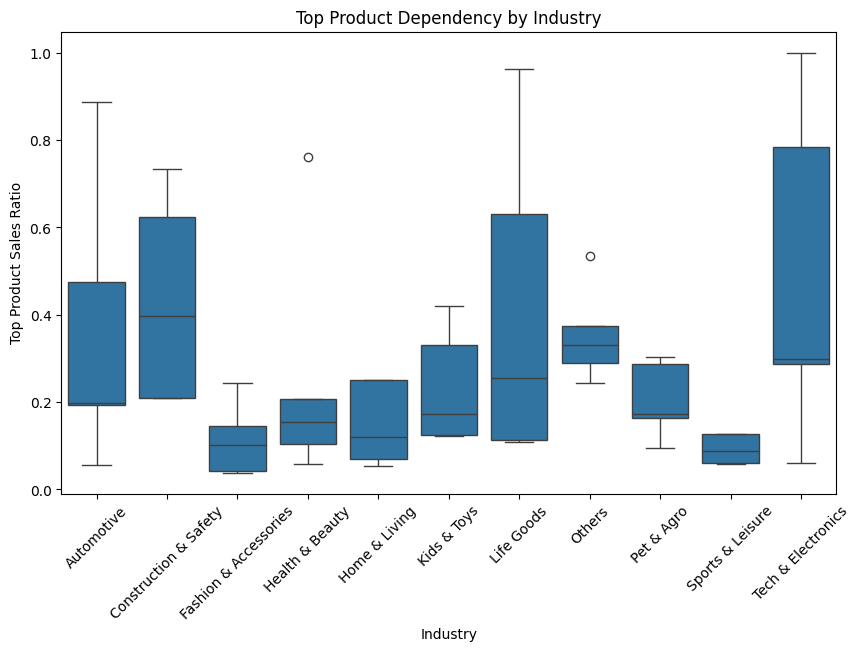

In [219]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(
    data=seller_metrics,
    x="industry",
    y="top_product_ratio"
)
plt.xticks(rotation=45)
plt.title("Top Product Dependency by Industry")
plt.ylabel("Top Product Sales Ratio")
plt.xlabel("Industry")
plt.show()


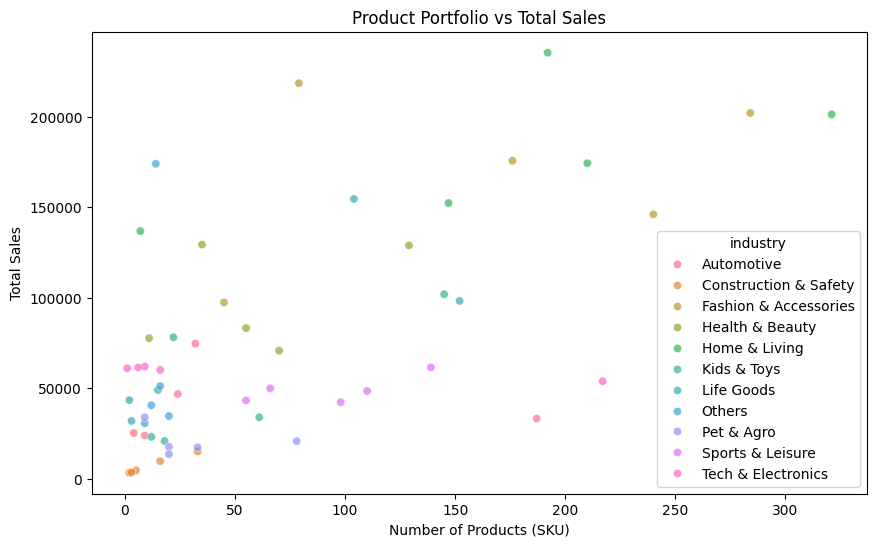

In [220]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=seller_metrics,
    x="product_cnt",
    y="total_sales",
    hue="industry",
    alpha=0.7
)
plt.title("Product Portfolio vs Total Sales")
plt.xlabel("Number of Products (SKU)")
plt.ylabel("Total Sales")
plt.show()


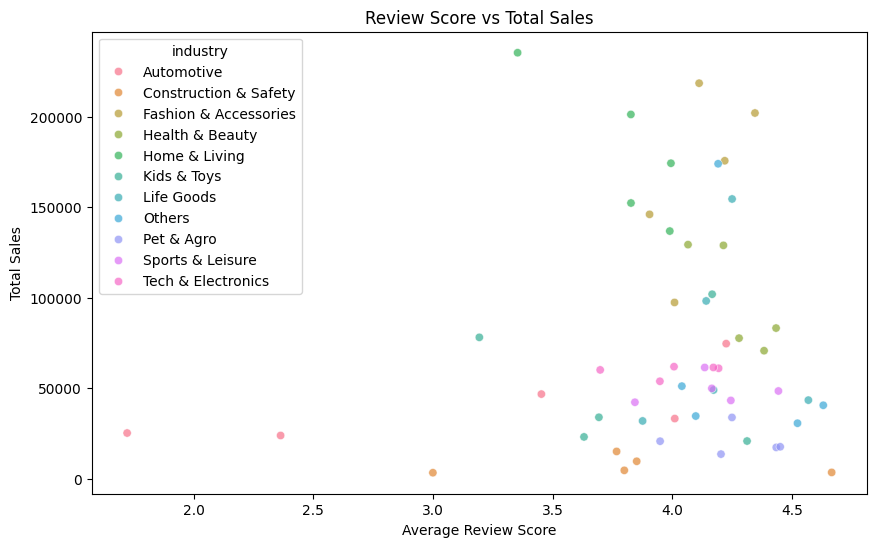

In [221]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=seller_metrics,
    x="avg_review_score",
    y="total_sales",
    hue="industry",
    alpha=0.7
)
plt.title("Review Score vs Total Sales")
plt.xlabel("Average Review Score")
plt.ylabel("Total Sales")
plt.show()


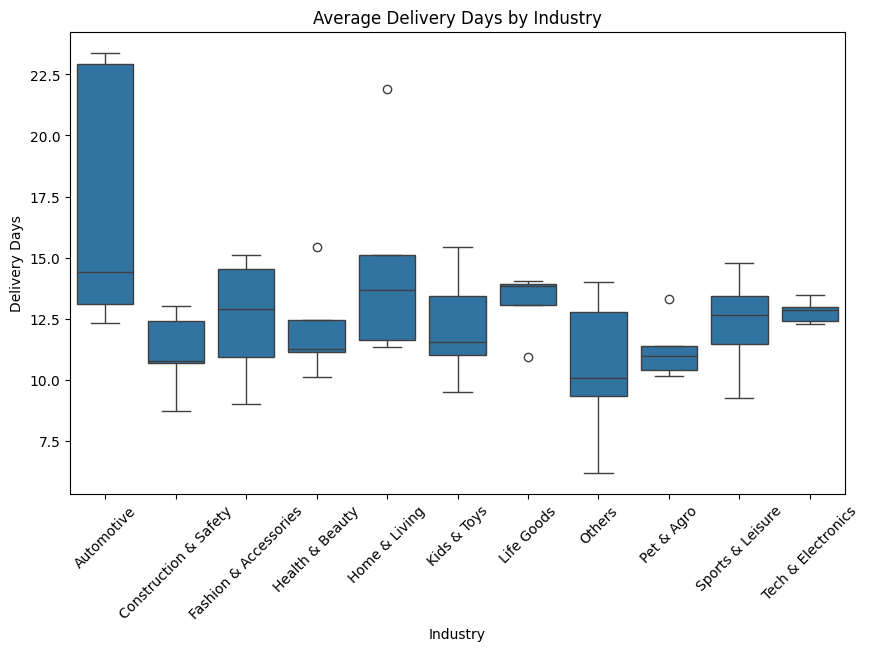

In [222]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=seller_metrics,
    x="industry",
    y="avg_delivery_days"
)
plt.xticks(rotation=45)
plt.title("Average Delivery Days by Industry")
plt.ylabel("Delivery Days")
plt.xlabel("Industry")
plt.show()


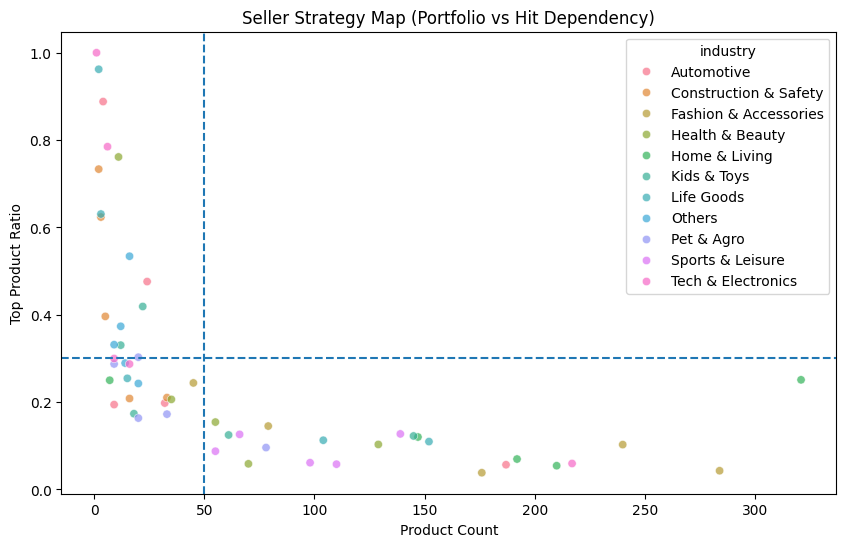

In [223]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=seller_metrics,
    x="product_cnt",
    y="top_product_ratio",
    hue="industry",
    alpha=0.7
)
plt.axhline(0.3, linestyle="--")
plt.axvline(50, linestyle="--")
plt.title("Seller Strategy Map (Portfolio vs Hit Dependency)")
plt.xlabel("Product Count")
plt.ylabel("Top Product Ratio")
plt.show()


In [224]:
hl = seller_metrics[seller_metrics["industry"] == "Home & Living"].copy()


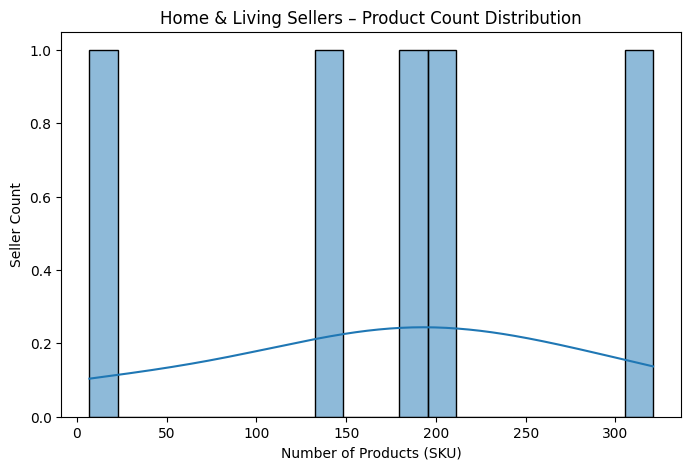

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(hl["product_cnt"], bins=20, kde=True)
plt.title("Home & Living Sellers – Product Count Distribution")
plt.xlabel("Number of Products (SKU)")
plt.ylabel("Seller Count")
plt.show()


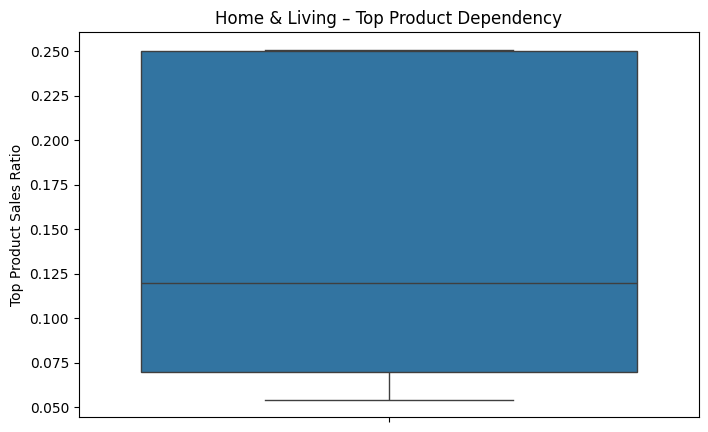

In [167]:
plt.figure(figsize=(8,5))
sns.boxplot(y=hl["top_product_ratio"])
plt.title("Home & Living – Top Product Dependency")
plt.ylabel("Top Product Sales Ratio")
plt.show()


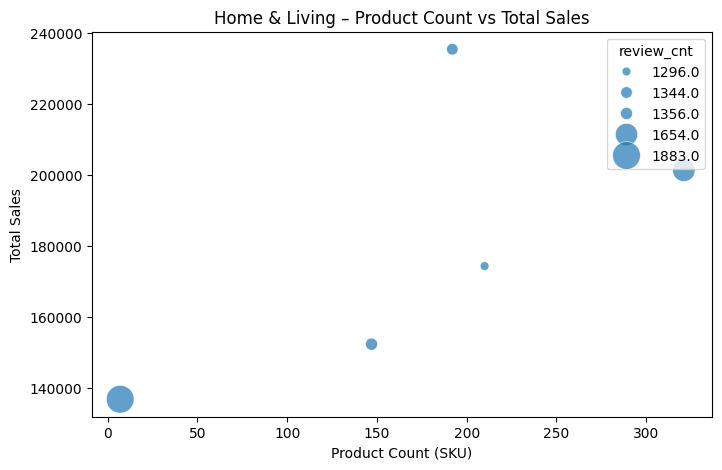

In [168]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=hl,
    x="product_cnt",
    y="total_sales",
    size="review_cnt",
    sizes=(40, 400),
    alpha=0.7
)
plt.title("Home & Living – Product Count vs Total Sales")
plt.xlabel("Product Count (SKU)")
plt.ylabel("Total Sales")
plt.show()


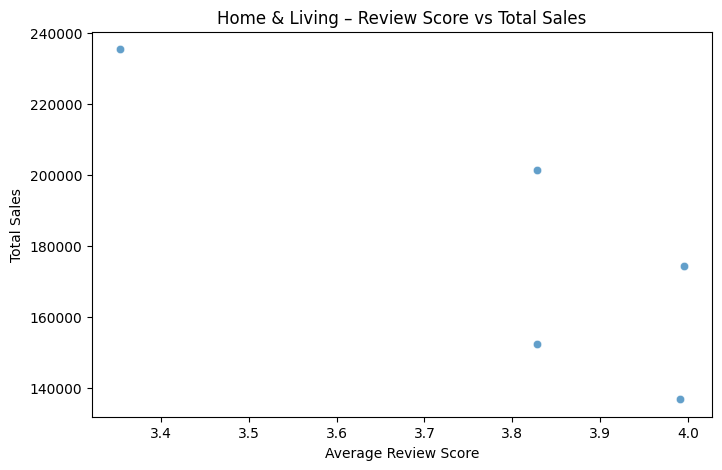

In [226]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=hl,
    x="avg_review_score",
    y="total_sales",
    alpha=0.7
)
plt.title("Home & Living – Review Score vs Total Sales")
plt.xlabel("Average Review Score")
plt.ylabel("Total Sales")
plt.show()


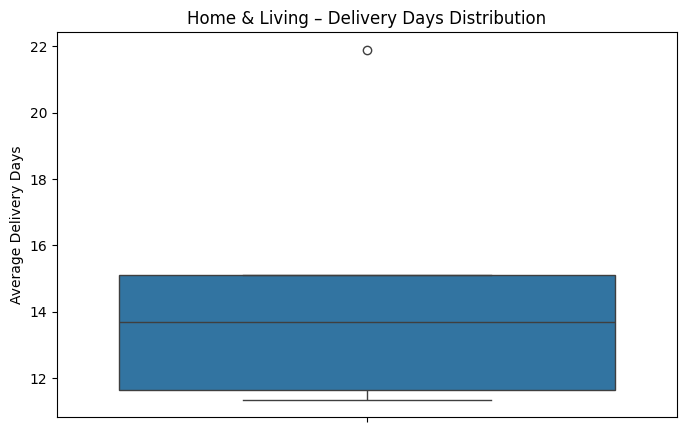

In [227]:
plt.figure(figsize=(8,5))
sns.boxplot(y=hl["avg_delivery_days"])
plt.title("Home & Living – Delivery Days Distribution")
plt.ylabel("Average Delivery Days")
plt.show()


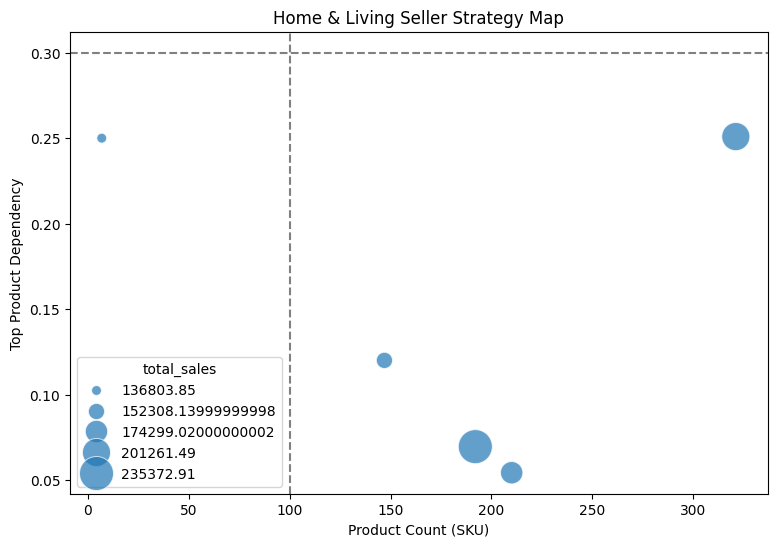

In [228]:
plt.figure(figsize=(9,6))
sns.scatterplot(
    data=hl,
    x="product_cnt",
    y="top_product_ratio",
    size="total_sales",
    sizes=(50, 600),
    alpha=0.7
)

plt.axhline(0.3, linestyle="--", color="gray")
plt.axvline(100, linestyle="--", color="gray")

plt.title("Home & Living Seller Strategy Map")
plt.xlabel("Product Count (SKU)")
plt.ylabel("Top Product Dependency")
plt.show()


In [229]:
hl = seller_total_metrics[
    seller_total_metrics["industry"] == "Home & Living"
].copy()

hl_sorted = hl.sort_values("total_sales", ascending=False).reset_index(drop=True)

top5 = hl_sorted.head(5)
bottom5 = hl_sorted.tail(5)

mid_start = len(hl_sorted)//4 - 2
mid5 = hl_sorted.iloc[mid_start:mid_start + 5]

compare_df = pd.concat([
    top5.assign(group="Top 5"),
    mid5.assign(group="Mid 5"),
    bottom5.assign(group="Bottom 5")
])
compare_df

,industry,seller_id,total_sales,product_cnt,avg_review_score,review_cnt,avg_delivery_days,seller_state,group
0,Home & Living,7c67e1448b00f6e969d365cea6b010ab,235372.91,192,3.354089,1344.0,21.900826,SP,Top 5
1,Home & Living,4a3ca9315b744ce9f8e9374361493884,201261.49,321,3.827523,1654.0,13.683303,SP,Top 5
2,Home & Living,da8622b14eb17ae2831f4ac5b9dab84a,174299.02,210,3.994894,1296.0,11.352941,SP,Top 5
3,Home & Living,1025f0e2d44d7041d6cf58b6550e0bfa,152308.14,147,3.827869,1356.0,11.640149,SP,Top 5
4,Home & Living,1f50f920176fa81dab994f9023523100,136803.85,7,3.990128,1883.0,15.117741,SP,Top 5
267,Home & Living,318f287a62ab7ac10b703ac37435a231,2431.81,6,3.818182,33.0,13.750000,SP,Mid 5
268,Home & Living,cd06602b43d8800bd0afad514919d35c,2430.98,19,3.660000,50.0,11.571429,SP,Mid 5
269,Home & Living,9dda5bbacd45e18d6485fee649205d09,2419.33,18,4.227273,22.0,14.227273,MG,Mid 5
270,Home & Living,0be8ff43f22e456b4e0371b2245e4d01,2404.78,27,3.868421,38.0,10.432432,SP,Mid 5
271,Home & Living,5cbbd5a299cab112b7bf23862255e43e,2339.51,11,4.235294,17.0,8.823529,PR,Mid 5


In [187]:
compare_cols = [
    "total_sales",
    "product_cnt",
    "avg_review_score",
    "review_cnt",
    "avg_delivery_days"
]

summary = compare_df.groupby("group")[compare_cols].mean()
summary


,total_sales,product_cnt,avg_review_score,review_cnt,avg_delivery_days
group,,,,,
Bottom 5,22.884,1.0,3.200000,1.0,5.500000
Mid 5,2405.282,16.2,3.961834,32.0,11.760933
Top 5,180009.082,175.4,3.798900,1506.6,14.738992


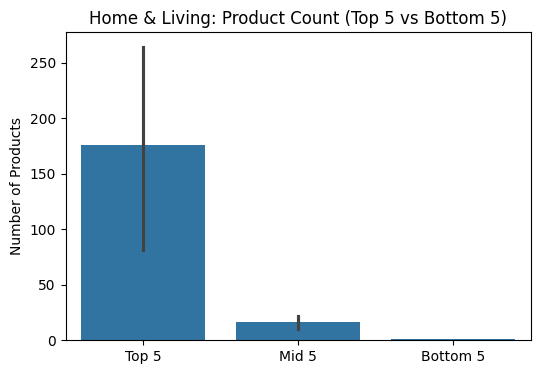

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.barplot(data=compare_df, x="group", y="product_cnt")
plt.title("Home & Living: Product Count (Top 5 vs Bottom 5)")
plt.ylabel("Number of Products")
plt.xlabel("")
plt.show()


In [230]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=compare_df,
    x="product_cnt",
    y="top_product_ratio",
    hue="group",
    size="total_sales",
    sizes=(200, 800),
    alpha=0.8
)

plt.axhline(0.3, linestyle="--", color="gray")
plt.axvline(100, linestyle="--", color="gray")

plt.title("Home & Living Seller Strategy Map")
plt.xlabel("Product Count (SKU)")
plt.ylabel("Top Product Dependency")
plt.show()

ValueError: Could not interpret value `top_product_ratio` for `y`. An entry with this name does not appear in `data`.

<Figure size 800x600 with 0 Axes>